In [186]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix,classification_report,f1_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# **EDA (Exploratory Data Analysis) **




In [141]:
data =pd.read_csv("/content/projectdata.xlsx - sheet 1.csv")
data

,quantity,UnitePrice,discount,date,retail price,product_name,area,city
0,33,16.0,20.0,2021-10-29T03:33:52Z,16.0,product y,Bahary,North
1,30,16.0,20.0,2021-10-23T12:29:27Z,16.0,product y,Dar El-Salam,Cairo
2,2,45.0,30.0,2021-08-03T09:14:16Z,45.0,product z,Miamy,North
3,3,16.0,3.0,2021-08-17T09:00:50Z,16.0,product y,Miamy,North
4,1,45.0,27.0,2021-09-06T19:57:02Z,45.0,product z,Miamy,North
...,...,...,...,...,...,...,...,...
2990,2,99.0,33.0,2022-12-05T09:48:42Z,99.0,product x,Dokki and Mohandessin,Giza
2991,2,99.0,33.0,2022-12-21T00:00:28Z,99.0,product x,Dokki and Mohandessin,Giza
2992,5,45.0,31.0,2022-12-27T08:43:38Z,45.0,product z,Dokki and Mohandessin,Giza
2993,1,99.0,32.0,2022-11-26T09:16:45Z,0.0,product x,El-Agamy,North


In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2995 non-null   int64  
 1   UnitePrice    2995 non-null   float64
 2   discount      2995 non-null   float64
 3   date          2995 non-null   object 
 4   retail price  2995 non-null   float64
 5   product_name  2995 non-null   object 
 6   area          2970 non-null   object 
 7   city          2995 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 187.3+ KB


In [143]:
data.describe()

,quantity,UnitePrice,discount,retail price
count,2995.000000,2995.000000,2995.000000,2995.000000
mean,7.705509,60.555426,25.917225,59.615776
std,100.466019,35.270286,14.124298,36.944778
min,1.000000,10.000000,-1.000000,0.000000
25%,2.000000,16.000000,20.000000,16.000000
50%,3.000000,45.000000,31.000000,45.000000
75%,5.000000,99.000000,33.000000,99.000000
max,5000.000000,102.000000,561.000000,102.000000


In [144]:
data.isnull().sum()

,0
quantity,0
UnitePrice,0
discount,0
date,0
retail price,0
product_name,0
area,25
city,0


<Axes: >

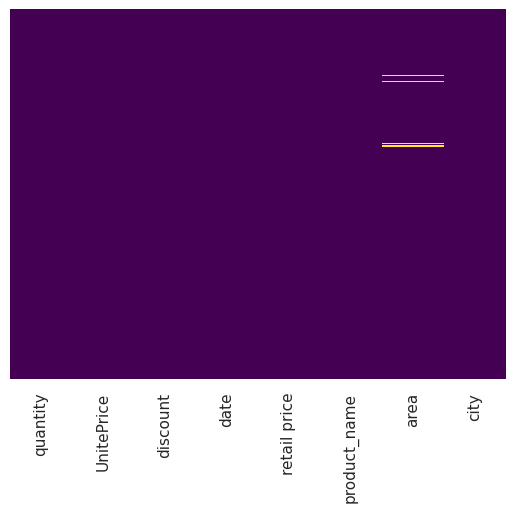

In [145]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')


In [146]:
data['revenue'] = data['quantity'] * data['UnitePrice']
data['revenue']

,revenue
0,528.0
1,480.0
2,90.0
3,48.0
4,45.0
...,...
2990,198.0
2991,198.0
2992,225.0
2993,99.0


In [147]:
#grouping data by product
product_sales = data.groupby('product_name').agg({
    'quantity': 'sum',
    'UnitePrice': 'mean',
    'discount': 'mean',
    'retail price': 'mean'
}).reset_index()

# Add a revenue column
product_sales['revenue'] = product_sales['quantity'] * product_sales['UnitePrice']

print(product_sales)

  product_name  quantity  UnitePrice   discount  retail price        revenue
0   product x       5730   96.049151  32.939173     94.539074  550361.637199
1    product y     14851   16.287318  11.913805     16.033670  241882.953984
2    product z      2497   44.982609  29.610000     44.326087  112321.573913


In [148]:
#grouping data by city
city_sales = data.groupby('city').agg({
    'quantity': 'sum',
    'UnitePrice': 'mean',
    'discount': 'mean'
}).reset_index()

city_sales['revenue'] = city_sales['quantity'] * city_sales['UnitePrice']

print(city_sales)




    city  quantity  UnitePrice   discount        revenue
0  Cairo      7537   63.450284  26.005597  478224.791193
1   Giza      8672   63.335938  26.367923  549249.250000
2  North      6869   58.523039  25.741271  401994.758300


In [149]:
#group data by city and area and get avg of sales per each area
area_sales = data.groupby(['city', 'area']).agg({
    'quantity': 'sum',
    'UnitePrice': 'mean',
    'discount': 'mean'
}).reset_index()

# Calculate revenue
area_sales['revenue'] = area_sales['quantity'] * area_sales['UnitePrice']

# Calculate average sales per area
area_sales['avg_sales_per_area'] = area_sales['revenue'] / area_sales['quantity']

print(area_sales)


     city          area  quantity  UnitePrice   discount       revenue  \
0   Cairo     Ain Shams       180   71.870690  28.379310  12936.724138   
1   Cairo     Badr City        20   16.000000   1.000000    320.000000   
2   Cairo  Dar El-Salam        69   30.000000  15.125000   2070.000000   
3   Cairo      El-Maadi      1136   71.827586  26.155172  81596.137931   
4   Cairo       El-Marg       461   47.448980  22.163265  21873.979592   
..    ...           ...       ...         ...        ...           ...   
65  North        Smouha       466   62.542230  27.108108  29144.679054   
66  North       Stanley        31   63.300000  28.000000   1962.300000   
67  North      Victoria        29   41.687500  25.500000   1208.937500   
68  North       Zizenia         5   92.833333  32.666667    464.166667   
69  North    Ø¹Ø¬Ù„ÙˆÙ†         5   65.166667  28.666667    325.833333   

    avg_sales_per_area  
0            71.870690  
1            16.000000  
2            30.000000  
3          

In [150]:
# Top products in each city
top_products_city = data.groupby(['city', 'product_name']).agg({
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index().sort_values(by='quantity', ascending=False)

print(top_products_city)

    city product_name  quantity    revenue
4   Giza    product y      6736  108958.00
1  Cairo    product y      4837   77868.00
7  North    product y      3278   53332.00
6  North   product x       2232  212734.00
0  Cairo   product x       2077  195104.75
3   Giza   product x       1421  136198.50
8  North    product z      1359   61155.00
2  Cairo    product z       623   28011.00
5   Giza    product z       515   23175.00


In [151]:
# Top products in each area
top_products_area = data.groupby(['area', 'product_name']).agg({
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index().sort_values(by='quantity', ascending=False)

print(top_products_area)

              area product_name  quantity  revenue
43        El-Haram    product y      5287  84712.0
130      Nasr City    product y      2563  41050.0
49        El-Maadi    product y      1018  16288.0
77       El-Seyouf    product y       616   9928.0
33        El-Agamy    product y       540   8652.0
..             ...          ...       ...      ...
19          Bulkly   product x          1     99.0
57     El-Mansoura   product x          1    102.0
74   El-Salam City   product x          1     99.0
141    San Stefano    product z         1     45.0
75   El-Salam City    product y         1     16.0

[167 rows x 4 columns]


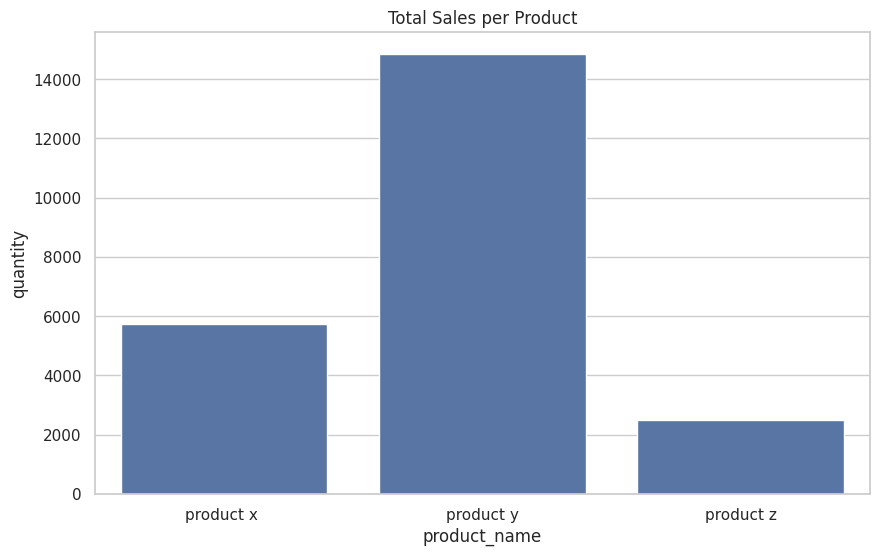

In [152]:
plt.figure(figsize=(10, 6))
sns.barplot(x='product_name', y='quantity', data=product_sales)
plt.title('Total Sales per Product')
plt.show()


<ipython-input-153-aef4e9f10455>:7: UserWarning: 
The palette list has fewer values (6) than needed (70) and will cycle, which may produce an uninterpretable plot.
  top_products_plot = sns.barplot(
<ipython-input-153-aef4e9f10455>:22: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


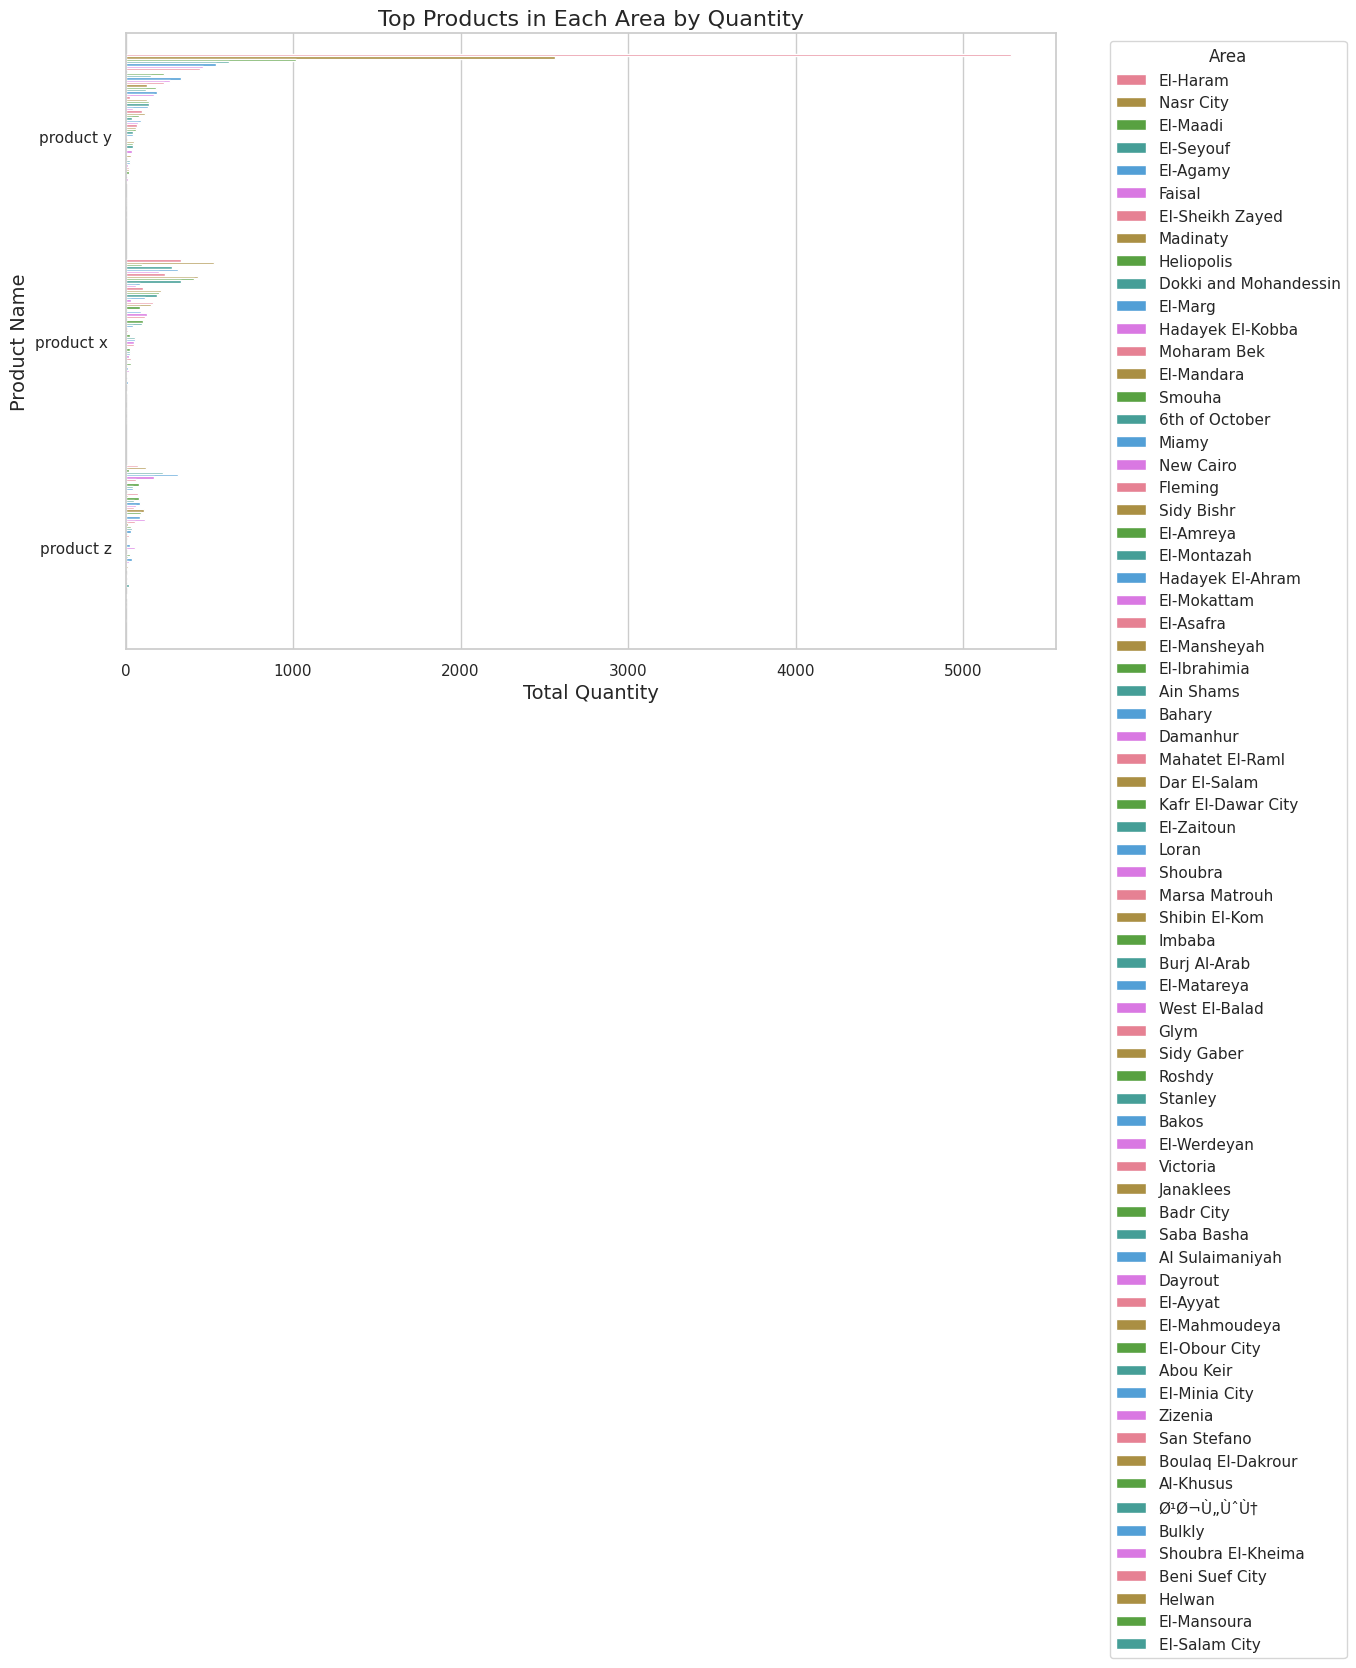

In [153]:
#top products on each area by quantity
sns.set(style="whitegrid")
distinct_palette = sns.color_palette("husl")

# Create a bar plot
plt.figure(figsize=(12, 8))
top_products_plot = sns.barplot(
    data=top_products_area,
    x='quantity',
    y='product_name',
    hue='area',
    palette=distinct_palette
)

# Title and labels
plt.title('Top Products in Each Area by Quantity', fontsize=16)
plt.xlabel('Total Quantity', fontsize=14)
plt.ylabel('Product Name', fontsize=14)

# Show plot
plt.legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

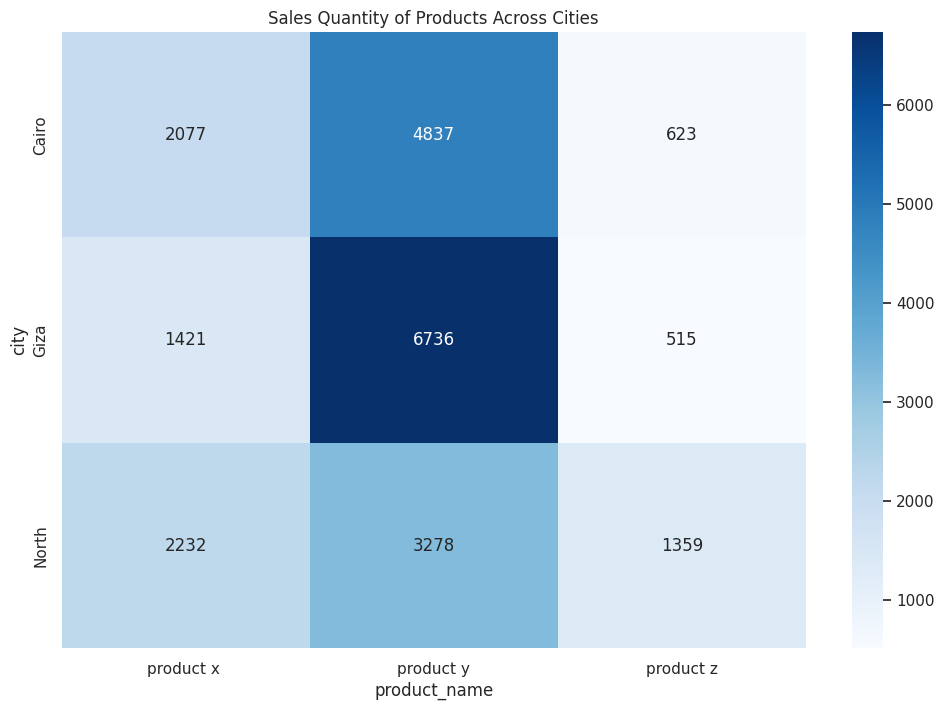

In [154]:
# Heatmap for city vs product sales
city_product_sales = data.pivot_table(index='city', columns='product_name', values='quantity', aggfunc='sum')
plt.figure(figsize=(12, 8))
sns.heatmap(city_product_sales, cmap='Blues', annot=True, fmt=".0f")
plt.title('Sales Quantity of Products Across Cities')
plt.show()

In [155]:
correlation = data['discount'].corr(data['quantity'])
print(f"Correlation between discount and sales quantity: {correlation:.2f}")


Correlation between discount and sales quantity: -0.04


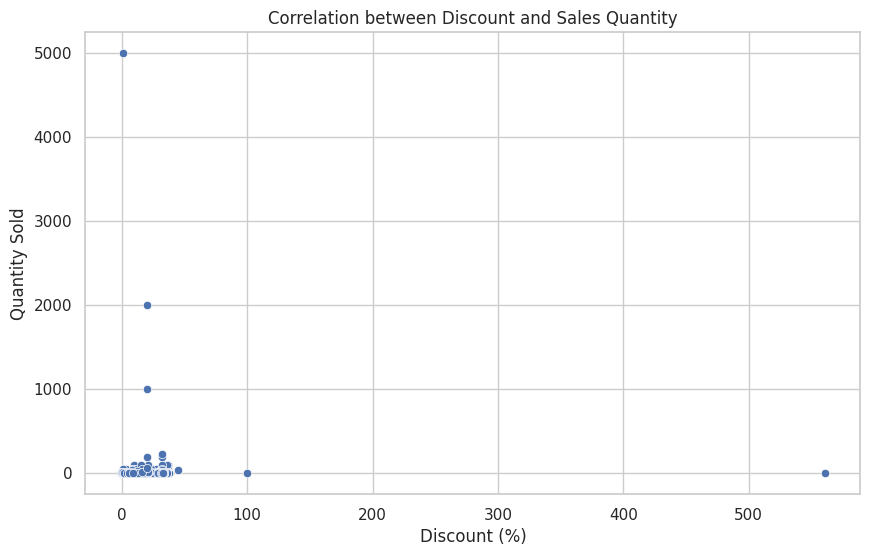

In [156]:
#visualiza discount and quantity
plt.figure(figsize=(10, 6))

sns.scatterplot(x='discount', y='quantity',data=data)

plt.title('Correlation between Discount and Sales Quantity')
plt.xlabel('Discount (%)')
plt.ylabel('Quantity Sold')

plt.show()

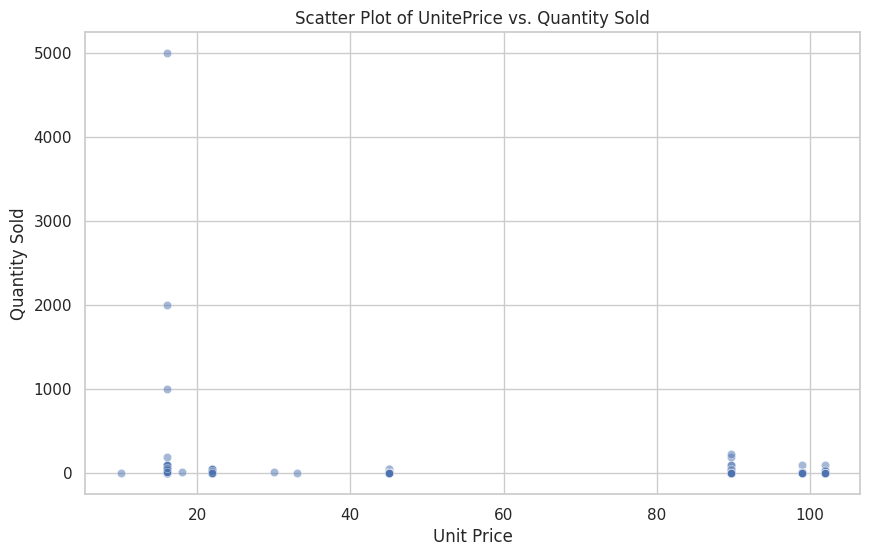

In [157]:
#visualize unite_price and quantity
plt.figure(figsize=(10, 6))

sns.scatterplot(x='UnitePrice', y='quantity', data=data, alpha=0.5)

plt.title('Scatter Plot of UnitePrice vs. Quantity Sold')
plt.xlabel('Unit Price')
plt.ylabel('Quantity Sold')

plt.show()

<Figure size 1200x800 with 0 Axes>

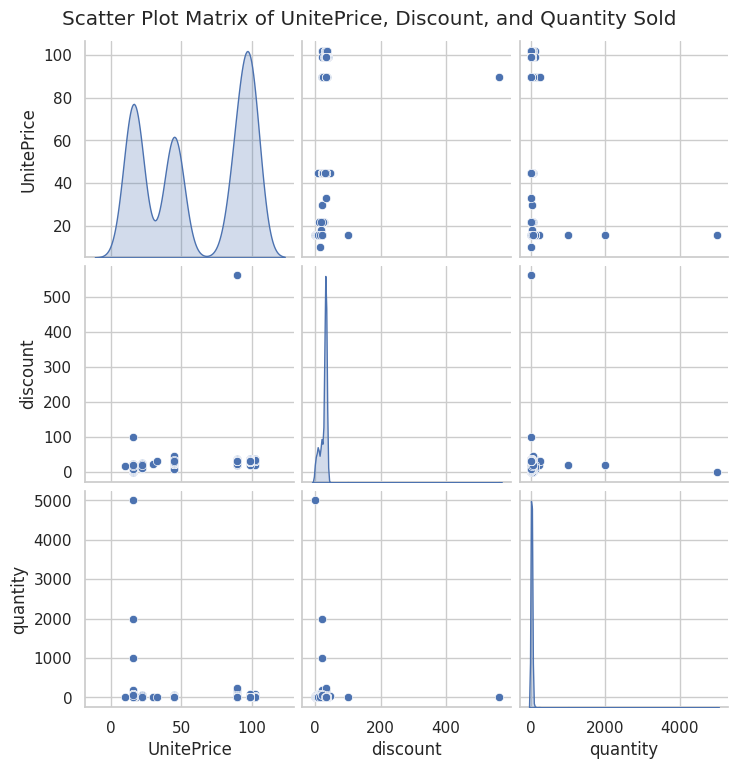

In [158]:
#get colrolation between unit price, discount and quantity
plt.figure(figsize=(12, 8))

sns.pairplot(data[['UnitePrice', 'discount', 'quantity']], diag_kind='kde')

plt.suptitle('Scatter Plot Matrix of UnitePrice, Discount, and Quantity Sold', y=1.02)

plt.show()

# Feature engineering

In [159]:
#convert object to numbers
object_data=[]
for i in data.columns:
    if data[i].dtypes=="object":
        object_data.append(i)
object_data

['date', 'product_name', 'area', 'city']

In [160]:
data_number=data.drop(object_data,axis=1)

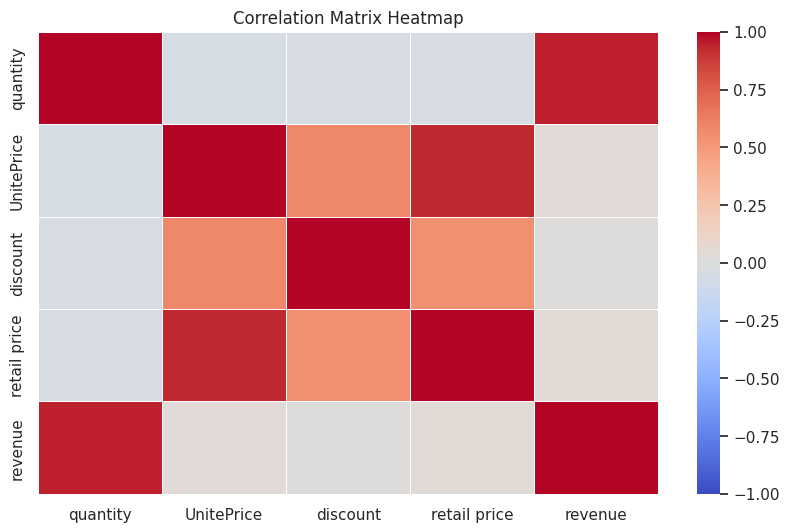

In [161]:
#get correlation_matrix for numerics columns
correlation_matrix=data_number.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix,cmap='coolwarm',vmin=-1,vmax=1,annot=False,linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

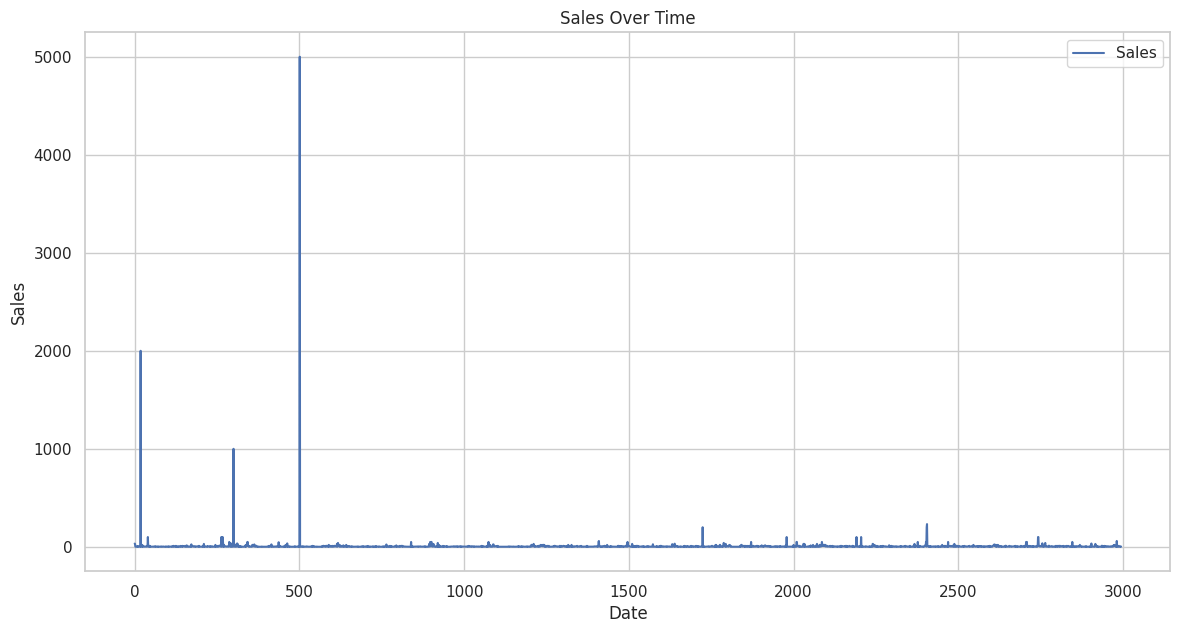

In [162]:

# Assuming 'date' is your time series index and 'sales' is the target variable
data['date'] = pd.to_datetime(data['date'])

# Plot the time series data
plt.figure(figsize=(14, 7))
plt.plot(data['quantity'], label='Sales')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()







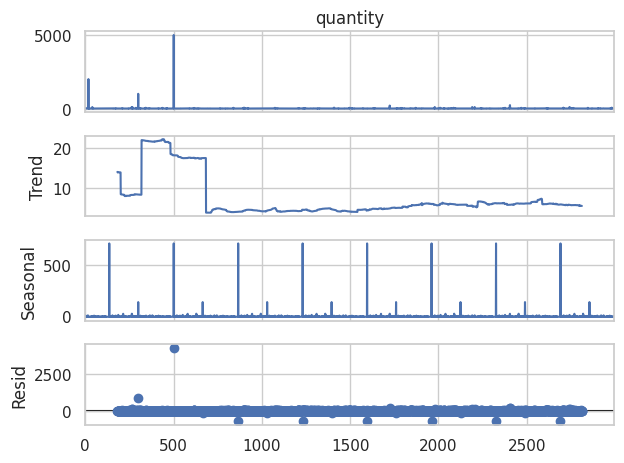

In [163]:
# Decompose the time series
decomposition = seasonal_decompose(data['quantity'], model='additive', period=365)
decomposition.plot()
plt.show()

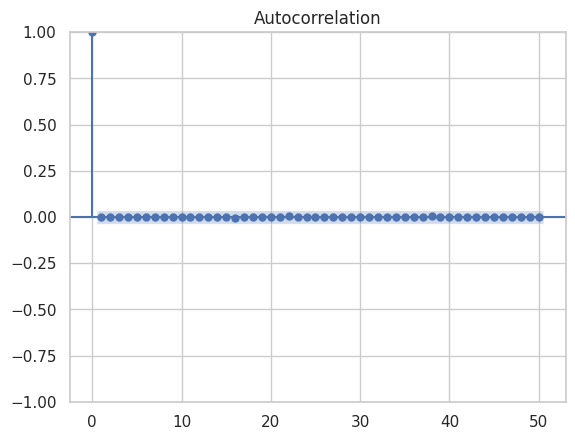

In [164]:
# Autocorrelation Plot
plot_acf(data['quantity'], lags=50)
plt.show()

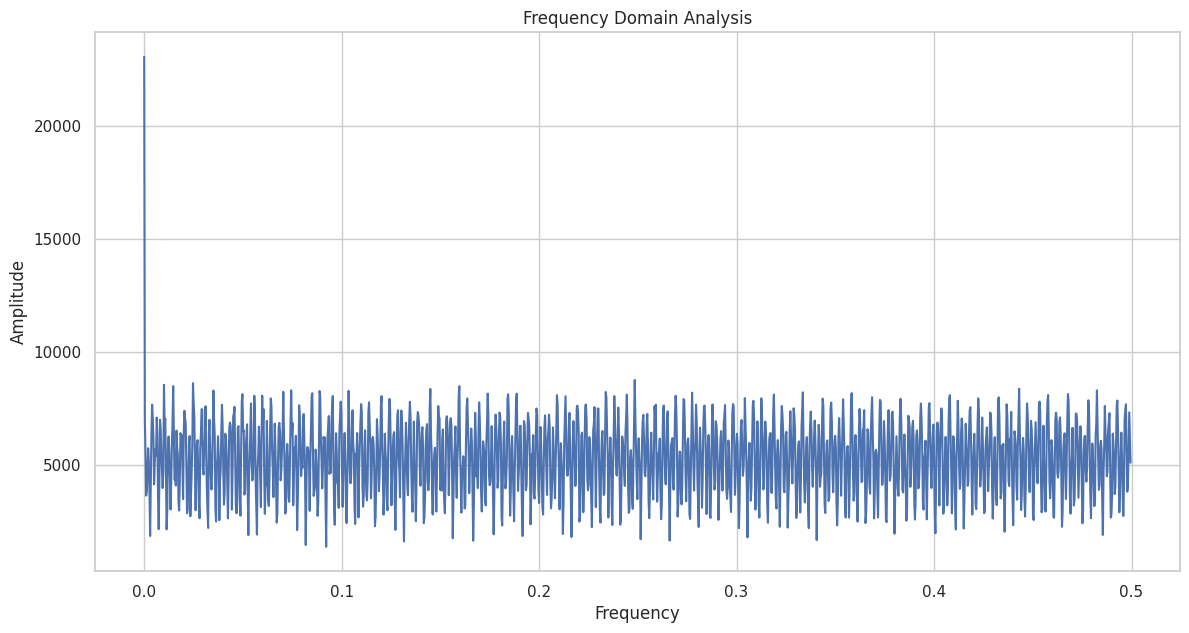

In [165]:

# Fourier Transform to analyze frequency domain
sales_fft = np.fft.fft(data['quantity'])
frequencies = np.fft.fftfreq(len(sales_fft))
plt.figure(figsize=(14, 7))
plt.plot(frequencies[:len(frequencies)//2], np.abs(sales_fft)[:len(sales_fft)//2])
plt.title('Frequency Domain Analysis')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

In [166]:
#feature engineering(null,object,outlier)

In [167]:
#solve null values
median_value = data['quantity'].median()
data['area'].fillna(median_value, inplace=True)


In [168]:
# Calculate target encoding to convert from object to number
mean_encoding_product = data.groupby('product_name')['quantity'].mean()
data['product_name_encoded'] = data['product_name'].map(mean_encoding_product)
mean_encoding_city = data.groupby('city')['quantity'].mean()
data['city_encoded'] = data['city'].map(mean_encoding_city)
mean_encoding_area = data.groupby('area')['quantity'].mean()
data['area_encoded'] = data['area'].map(mean_encoding_area)


In [169]:
#covert date from object to date time and extract more informaations years, months, days
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek

In [170]:
def detect_outliers_iqr(df):
    outliers_indices = []
    for column in df.columns:
        if df[column].dtype != 'object':
            Q1 = np.percentile(df[column], 25)
            Q3 = np.percentile(df[column], 75)
            IQR = Q3 - Q1
            outlier_step = 1.5 * IQR
            outliers = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
            outliers_indices.extend(outliers)
    return list(set(outliers_indices))

# Detect outliers
outliers_indices = detect_outliers_iqr(data_number)
print(f'Number of outliers detected: {len(outliers_indices)}')

Number of outliers detected: 481


In [171]:
data_cleaned = data.drop(outliers_indices).reset_index(drop=True)


# Build Model

In [172]:
features = ['UnitePrice', 'discount', 'year', 'month', 'day', 'day_of_week', 'product_name_encoded', 'city_encoded', 'area_encoded']
X = data_cleaned[features]
y = data_cleaned['quantity']
y=y.values.reshape(-1,1)
y

array([[2],
       [3],
       [1],
       ...,
       [5],
       [1],
       [2]])

In [173]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


In [174]:
y_train

array([[5],
       [4],
       [1],
       ...,
       [7],
       [2],
       [5]])

In [175]:

#min and max scaler to scale  input data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

original_columns = X_train.columns
original_columns_test=X_test.columns

In [176]:
#build model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
model.fit(X_train_scaled, y_train)

y_pred = (model.predict(X_test_scaled)).astype(int)


In [177]:
model.score(X_train_scaled,y_train)

0.8758298642762711

In [178]:
#the last date to satrt predict after it
max_date=data_cleaned["date"].max()
print(max_date)

2023-01-17 09:24:09+00:00


In [179]:

# Generate future dates
future_dates = pd.date_range(start='2023-01-18 09:24:09+00:00', periods=10, freq='D') #max date =17 so i'll start from 18
future_data = []

for date in future_dates:
    for product in data_cleaned['product_name'].unique():
        for city in data_cleaned['city'].unique():
            row = {
                'year': date.year,
                'month': date.month,
                'day': date.day,
                'day_of_week': date.dayofweek,
                'UnitePrice': data_cleaned[data_cleaned['product_name'] == product]['UnitePrice'].mean(), #I will get mean to use it to predict new values
                'discount': data_cleaned[data_cleaned['product_name'] == product]['discount'].mean(),
                'product_name_encoded': mean_encoding_product.get(product, 0),
                'city_encoded': mean_encoding_city.get(city, 0),
                'area_encoded': mean_encoding_area.get(data_cleaned[data_cleaned['product_name'] == product]['area'].mode()[0], 0)#get mode for each area to know most area repreat
            }
            future_data.append(row)

# Convert to DataFrame
future_df = pd.DataFrame(future_data)

# Handle missing columns in future_df
for col in original_columns:
    if col not in future_df.columns:
        future_df[col] = 0

# Ensure columns are in the same order as original_columns
future_df = future_df[original_columns]

# Apply the same MinMaxScaler to the future_df
future_df_scaled = scaler.transform(future_df)

# Predict future sales
future_predictions = model.predict(future_df_scaled)
future_predictions

array([3.2614036, 3.55293  , 2.736923 , 4.6372705, 4.646383 , 4.1175866,
       3.8584259, 3.0534382, 2.9003637, 2.4307735, 2.6202922, 2.374158 ,
       3.9209   , 3.8280056, 3.578074 , 3.8299146, 2.823196 , 3.050985 ,
       1.7492449, 1.9572474, 1.8682239, 3.2936258, 3.2192621, 3.1264417,
       3.654479 , 2.6162763, 2.9845107, 2.1261318, 2.3341339, 2.156036 ,
       2.9971395, 2.9227757, 2.7753897, 4.039809 , 3.0749583, 3.5722272,
       2.2864969, 2.3972743, 2.4066434, 2.7691925, 2.7983816, 2.977237 ,
       3.2830472, 2.6098146, 3.2945514, 3.053199 , 3.43494  , 2.803582 ,
       3.2395062, 3.4101853, 3.3503802, 3.4595432, 2.2753499, 2.4197733,
       3.147984 , 3.1896064, 2.6866412, 2.734445 , 2.5650055, 2.4007401,
       3.2172554, 2.311866 , 2.5337875, 2.359685 , 2.4914951, 2.2116475,
       2.9691923, 2.8899403, 3.1244154, 3.4541926, 2.4435766, 3.6026537,
       1.8002479, 1.9320583, 2.0437486, 2.8344111, 2.7551596, 3.090164 ,
       3.7731447, 2.689508 , 4.105504 , 2.057716 , 

In [180]:
future_df

,UnitePrice,discount,year,month,day,day_of_week,product_name_encoded,city_encoded,area_encoded
0,44.981250,29.552969,2023,1,18,2,3.618841,3.931883,3.720000
1,44.981250,29.552969,2023,1,18,2,3.618841,10.705966,3.720000
2,44.981250,29.552969,2023,1,18,2,3.618841,15.941176,3.720000
3,16.252427,11.703236,2023,1,18,2,16.667789,3.931883,3.880399
4,16.252427,11.703236,2023,1,18,2,16.667789,10.705966,3.880399
...,...,...,...,...,...,...,...,...,...
85,16.252427,11.703236,2023,1,27,4,16.667789,10.705966,3.880399
86,16.252427,11.703236,2023,1,27,4,16.667789,15.941176,3.880399
87,96.118033,32.508591,2023,1,27,4,4.052334,3.931883,11.808824
88,96.118033,32.508591,2023,1,27,4,4.052334,10.705966,11.808824


In [181]:
forecast_results = pd.DataFrame({
    'date': future_dates.repeat(len(data_cleaned['product_name'].unique()) * len(data_cleaned['city'].unique())),
    'product_name': [prod for prod in data_cleaned['product_name'].unique() for _ in range(len(future_dates) * len(data_cleaned['city'].unique()))],
    'city': [c for _ in data_cleaned['product_name'].unique() for c in data_cleaned['city'].unique() for _ in range(len(future_dates))],
    'predicted_quantity': future_predictions
})
forecast_results

,date,product_name,city,predicted_quantity
0,2023-01-18 09:24:09+00:00,product z,North,3.261404
1,2023-01-18 09:24:09+00:00,product z,North,3.552930
2,2023-01-18 09:24:09+00:00,product z,North,2.736923
3,2023-01-18 09:24:09+00:00,product z,North,4.637270
4,2023-01-18 09:24:09+00:00,product z,North,4.646383
...,...,...,...,...
85,2023-01-27 09:24:09+00:00,product x,Giza,3.193031
86,2023-01-27 09:24:09+00:00,product x,Giza,3.757134
87,2023-01-27 09:24:09+00:00,product x,Giza,3.543937
88,2023-01-27 09:24:09+00:00,product x,Giza,2.281502


# Evaluate model

Mean Squared Error: 2.337972166998012
Mean Absolute Error: 1.1093439363817097
R-squared: -0.01550917262667073


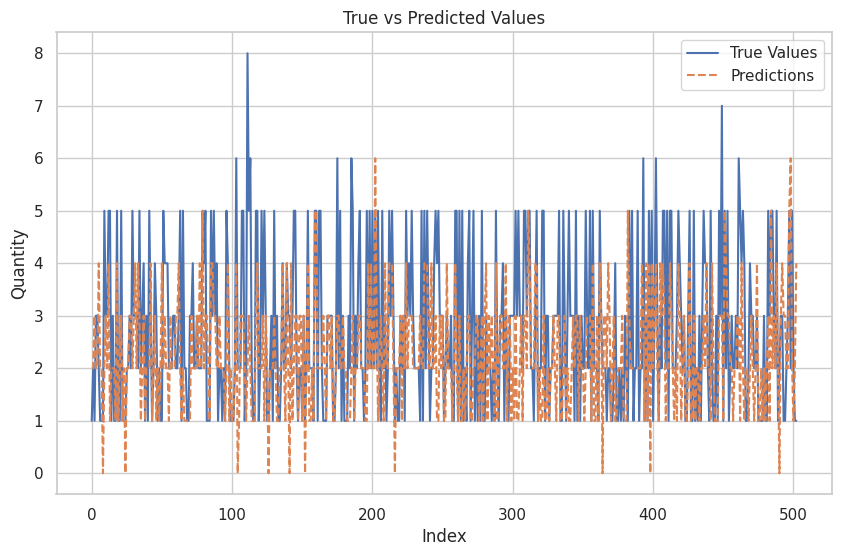

In [182]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squre = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r_squre}")

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predictions', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Quantity')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [183]:
precision = precision_score(y_test, y_pred, average='micro', zero_division=1)
recall = recall_score(y_test, y_pred, average='micro', zero_division=1)
f1=f1_score(y_test, y_pred, average='micro', zero_division=1)
print(f"Mean Squared Error: {mse}")

print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)



Mean Squared Error: 2.337972166998012
Precision: 0.32007952286282304
Recall: 0.32007952286282304
f1: 0.32007952286282304


In [184]:
classification_report=classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:\n", classification_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       0.46      0.41      0.43       136
           2       0.31      0.45      0.36       129
           3       0.31      0.33      0.32       105
           4       0.09      0.21      0.12        24
           5       0.88      0.07      0.13       100
           6       0.00      0.00      1.00         7
           7       1.00      0.00      0.00         1
           8       1.00      0.00      0.00         1

    accuracy                           0.32       503
   macro avg       0.45      0.27      0.26       503
weighted avg       0.45      0.32      0.32       503



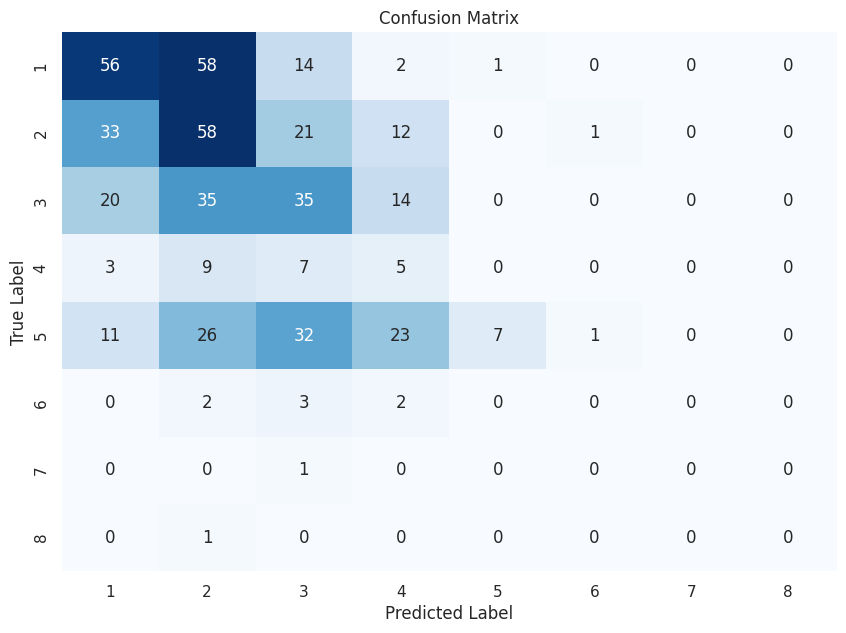

In [185]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))


plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()